- The "A" variant consists of cases with confirmed diagnoses (i.e., RT-PCR, radiologist-confirmed, etc.).

- label structure: filename class xmin ymin xmax ymax

- Classes are zero-indexed with Normal=0, Pneumonia=1, and COVID-19=2, and bounding boxes are given in original image coordinates. Example code for loading images and bounding boxes is given in the starter notebook.

In [3]:
import sys ,os
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)
    
import configparser
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import utils as Utils
import bbox_utils as BboxUtils
from data_processing.data_processing_functions import *
from importlib import reload
import cv2

reload(Utils)
reload(BboxUtils)
config = configparser.ConfigParser()
config.read("../../config.ini")
pd.set_option('display.max_colwidth', None)

In [4]:
KAGGLE_COVID_CT_PATH = config['PATHS']['KAGGLE_COVID_CT_PATH']
KAGGLE_COVID_METADATA_PATH = os.path.join(KAGGLE_COVID_CT_PATH, 'metadata.csv')
KAGGLE_COVID_IMAGES_PATH = os.path.join(KAGGLE_COVID_CT_PATH, '3A_images')
LABEL_TO_INDEX_DICT = {
    "Normal":0,
    "Pneumonia":1,
    "COVID-19":2
}
INDEX_TO_LABEL_DICT = {
    0:"Normal",
    1:"Pneumonia",
    2:"COVID-19"
}


In [5]:
kaggle_meta_df = pd.read_csv(KAGGLE_COVID_METADATA_PATH)
print(kaggle_meta_df.shape)
kaggle_meta_df.head(20)

(6068, 10)


,patient id,source,country,sex,age,finding,verified finding,slice selection,view,modality
0,CP_0,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
1,CP_10,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
2,CP_1068,CNCB,China,NaN,NaN,Pneumonia,Yes,Automatic,Axial,CT
3,CP_1070,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
4,CP_1071,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
5,CP_1072,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
6,CP_1073,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
7,CP_1075,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
8,CP_1076,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT
9,CP_1077,CNCB,China,NaN,NaN,Pneumonia,Yes,Expert,Axial,CT


In [12]:
kaggle_meta_df["source"].value_counts()

source
CNCB               1854
STOIC              1176
MosMedData          756
iCTCF               709
TCIA                643
COVID-CTset         377
COVID-CT-MD         301
radiopaedia.org     105
Stony Brook          90
LIDC-IDRI            39
COVID-19-CT-Seg      18
Name: count, dtype: int64

In [20]:
kaggle_meta_df["finding"].value_counts()

finding
COVID-19     4487
Pneumonia     932
Normal        649
Name: count, dtype: int64

In [14]:
print(f"Number of images: {len(os.listdir(KAGGLE_COVID_IMAGES_PATH))}")

Number of images: 425024


In [19]:
anns_df = BboxUtils.generate_kaggle_dataset(KAGGLE_COVID_CT_PATH)
print(anns_df.shape)
print(anns_df["label"].value_counts())
anns_df.head()

(425024, 8)
label
2    310593
0     71488
1     42943
Name: count, dtype: int64


,image_id,image_path,label,x_min,y_min,x_max,y_max,database_id
0,HUST-Patient1268-0062.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/Kaggle/archive/3A_images/HUST-Patient1268-0062.png,2,0,120,505,444,HUST
1,coronacases_007-0086.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/Kaggle/archive/3A_images/coronacases_007-0086.png,2,25,58,476,371,coronacases_007
2,STOIC-8338-0210.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/Kaggle/archive/3A_images/STOIC-8338-0210.png,2,0,124,505,424,STOIC
3,STOIC-10351-0138.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/Kaggle/archive/3A_images/STOIC-10351-0138.png,2,18,38,505,366,STOIC
4,HUST-Patient97-0246.png,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/Kaggle/archive/3A_images/HUST-Patient97-0246.png,2,44,128,487,413,HUST


In [10]:
# count number of images per databasewith 20 rows limit
print(anns_df["database_id"].value_counts()[:50])

database_id
STOIC                     192361
HUST                       45912
COVIDCTMD                  23280
volume                     11816
LIDC                        3999
radiopaedia                 3574
A292777                      916
A829297                      797
A978197                      448
A765481                      426
A524254                      397
A002304                      356
A438102                      354
A700420                      341
A561224                      311
A549020                      293
A056642                      292
A087492                      291
A523411                      282
A225093                      269
A727764                      252
A198259                      234
A951258                      230
A603249                      227
A789646                      218
A704496                      218
A201660                      215
A531756                      214
A918899                      210
A616705                      20

In [21]:
# get only rows with database_id in the list
databases_to_keep = ["STOIC", "HUST", "COVIDCTMD", "LIDC"]
anns_to_keep_df = anns_df[anns_df["database_id"].isin(databases_to_keep)]
print(anns_to_keep_df.shape)
print(anns_to_keep_df["label"].value_counts())

(242272, 8)
label
2    238273
0      3999
Name: count, dtype: int64


In [24]:
anns_df.to_pickle(os.path.join(KAGGLE_COVID_CT_PATH, 'processed_anns_df.pkl'))

## Visualization

Bounding boxes do only enclose the interest area, but not the infection itself

AttributeError: 'tuple' object has no attribute 'upper'

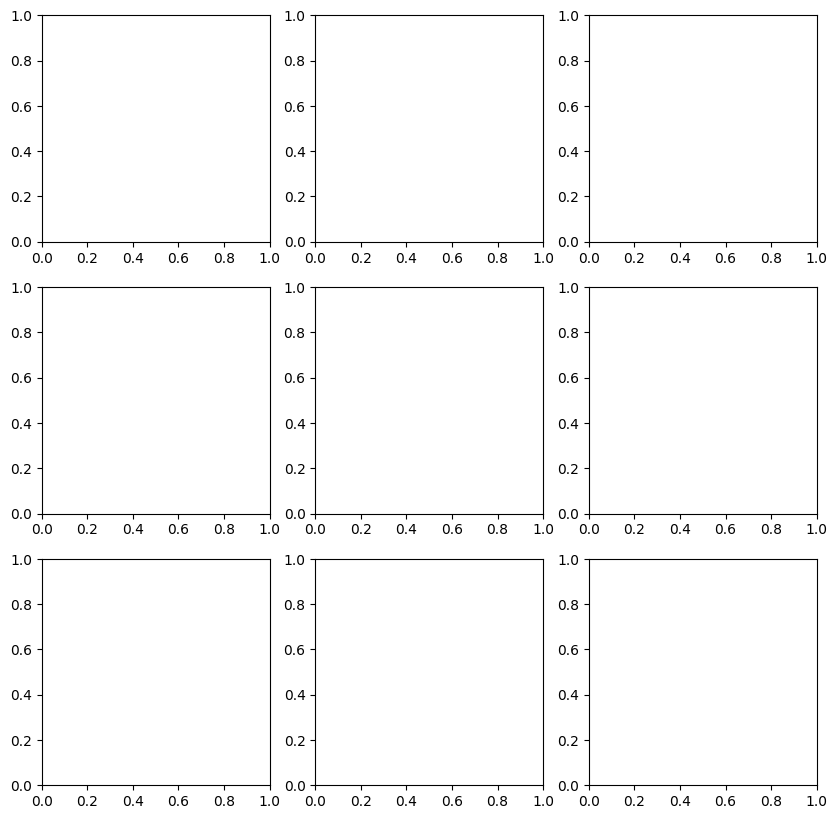

In [11]:
fig = plt.subplots(3,3 ,figsize=(10,10))
for i in range(9):
    row = anns_df.sample(9).iloc[i]
    img = cv2.imread(row["image_path"])
    bbox = BboxUtils.get_bbox_from_row(row)
    img = BboxUtils.draw_image_and_bbox(img, bbox, INDEX_TO_LABEL_DICT[row["label"]], (255,0,0))
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis("off")